In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
import scipy.optimize as sopt

from sklearn import datasets
from sklearn import metrics

In [3]:
from common.gradients import check_gradient, numerical_gradient, encode_params, decode_params

# Problem 3

IrisXFull is a (5, 150)-shaped matrix of float64
IrisX2feats is a (3, 150)-shaped matrix of float64
IrisY is a (1, 150)-shaped matrix of int64


/opt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


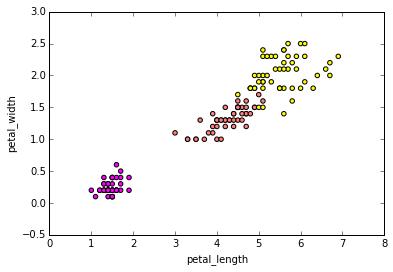

In [4]:
#
# Here we load the IRIS dataset.
# We will create two datasets: one using all features, and one using just Petal Langth and Petal Width for visualizations
#
iris = datasets.load_iris()
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

IrisXFull = np.vstack([np.ones_like(petal_length), iris.data.T])
IrisX2feats = np.vstack([np.ones_like(petal_length), petal_length, petal_width])
IrisY = iris.target.reshape(1,-1).astype(np.int64)

print "IrisXFull is a %s-shaped matrix of %s" % (IrisXFull.shape, IrisXFull.dtype)
print "IrisX2feats is a %s-shaped matrix of %s" % (IrisX2feats.shape, IrisX2feats.dtype)
print "IrisY is a %s-shaped matrix of %s" % (IrisY.shape, IrisY.dtype)

scatter(IrisX2feats[1,:], IrisX2feats[2,:], c=IrisY.ravel(), cmap='spring')
xlabel('petal_length')
ylabel('petal_width')

In [5]:
def SoftMaxRegression_implementation(ThetaFlat, X, Y=None, return_probabilities=False):
    """
    Compute the outputs of a softmax classifier, or the loss and gradient
    
    Parameters
    ----------
    ThetaFlat : 
        flat array of parameters containing (n_features*n_classes) entries
    X :
        array of features, shape n_features x n_smaples
    Y :
        optional array of desired targets of shape 1 x n_samples
    return_probabilities : 
        if True, the probabilities are returned and Y is not used
        if False, the los and gradient is computed on the X,Y pairs
    """
    #X is num_features x num_samples
    num_features, num_samples = X.shape

    #Theta is num_features x num_classes
    #we first reshape ThetaFlat into Theta
    Theta = ThetaFlat.reshape(num_features, -1)

    #Activation of softmax neurons
    #A's shape should be num_classes x num_samples
    A = np.dot(Theta.T, X)
    
    #Now compute the SoftMax function
    #O will be a num_classes x num_samples matrix of probabilities assigned by our model  
    #Stability optimization - for each subtract the maximum activation
    O = A - A.max(0, keepdims=True)
    #
    O = np.exp(O)
    O /= np.sum(O, axis=0)

    if return_probabilities:
        return O
    
    #The loss is the average per-sample nll (neg log likelihood)
    #The nll is the sum of the logarithms of probabilities assigned to each class
    correct_class_likelihoods = np.log(O[Y.ravel(), np.arange(num_samples)])
    L = - 1.0/num_samples * np.sum(correct_class_likelihoods)
    
    CVK = np.zeros(O.shape)
    CVK[Y.ravel(), np.arange(num_samples)] = 1
    
    dLdA = O - CVK
    dLdA /= num_samples

    #Now we compute the gradient of the loss with respect to Theta
    dLdTheta = np.dot(X, dLdA.T)

    #reshape gard into the shape of Theta, for fmin_l_bfsgb to work
    return L, dLdTheta.reshape(ThetaFlat.shape)

#Make a function for training on irises
iris_log_reg_cost = lambda Theta: SoftMaxRegression_implementation(Theta, IrisXFull, IrisY, False)
#Make sure that the gradient computation is OK
check_gradient(iris_log_reg_cost, np.zeros((3*5,)))
check_gradient(iris_log_reg_cost, np.random.rand(3*5)*2.0-1.0)

True

In [6]:
#
# Call a solver
#

#iprint will cause the solver to print TO THE TERMINAL from which ipython notebook was started
ThetaOpt = sopt.fmin_l_bfgs_b(iris_log_reg_cost, np.zeros((3*5,)), iprint=1)[0]

check_gradient(iris_log_reg_cost, ThetaOpt)

True

In [7]:
#
# Compute training errors
#
probabilities = SoftMaxRegression_implementation(ThetaOpt, IrisXFull, return_probabilities=True)
predictions = np.argmax(probabilities,0)

print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 98.666667%


In [8]:
#
# Now redo the training for two features
#
# TODO - again, use l_bfgs to find optimal theta, then compute probabilities and new predictions.
#
iris2_log_reg_cost = lambda Theta: SoftMaxRegression_implementation(Theta, IrisX2feats, IrisY, False)

Theta2class = sopt.fmin_l_bfgs_b(iris2_log_reg_cost, np.zeros((3*3,)), iprint=1)[0]
probabilities = SoftMaxRegression_implementation(Theta2class, IrisX2feats, return_probabilities=True)

print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 98.666667%


In [13]:
#
# Now plot the decision boundary
# 

petal_lengths, petal_widths = np.meshgrid(np.linspace(IrisX2feats[1,:].min(), IrisX2feats[1,:].max(), 100),
                                          np.linspace(IrisX2feats[2,:].min(), IrisX2feats[2,:].max(), 100))

IrisXGrid = np.vstack([np.ones(np.prod(petal_lengths.shape)), petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid = SoftMaxRegression_implementation(Theta2class, IrisXGrid, return_probabilities=True).argmax(0)

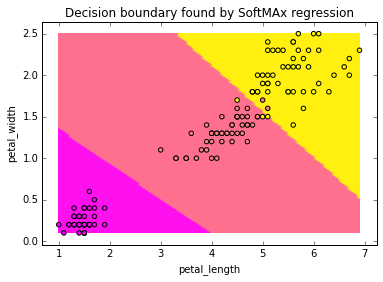

In [14]:
contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
scatter(IrisX2feats[1,:], IrisX2feats[2,:], c=IrisY.ravel(), cmap='spring')
xlabel('petal_length')
ylabel('petal_width')
title('Decision boundary found by SoftMAx regression')

# Problem 4

Please note, that we **move the addition of the bias term** into the network implementation! Please note, that typically instead of changing the inputs we keep another vector of bias terms.

In [17]:
def TwoLayerNet_implementation(ThetaFlat, ThetaShapes, X, Y=None, return_probabilities=False):
    """
    Compute the outputs of a softmax classifier, or the loss and gradient
    
    Parameters
    ----------
    ThetaFlat : 
        flat array of parameters
    ThetaShapes :
        list of shapes of weight and bias matrices
    X :
        array of features, shape n_features x n_smaples
    Y :
        optional array of desired targets of shape 1 x n_samples
    return_probabilities : 
        if True, the probabilities are returned and Y is not used
        if False, the los and gradient is computed on the X,Y pairs
    """
    #X is num_features x num_samples
    num_features, num_samples = X.shape

    #Extract weight matrices
    W1, W2 = decode_params(ThetaFlat, ThetaShapes)
    
    X_padded = np.vstack([np.ones((1, num_samples)), X])
    
    #Activation in first layer. Shape is num_hidden x num_samples
    #
    A1 = np.dot(W1.T, X_padded)
    #

    #Apply the transfer function
    #
    H1 = np.tanh(A1)
    #
        
    #Pad with zeros (ones!)
    H1_padded = np.vstack([np.ones((1, num_samples)), H1])
    
    #Now apply the second linear transform
    #
    A2 = np.dot(W2.T, H1_padded)
    
    #Now compute the SoftMax function
    #O will be a num_classes x num_samples matrix of probabilities assigned by our model  
    #Stability optimization - for each subtract the maximum activation
    O = A2 - A2.max(0, keepdims=True)    
    # 
    # TODO - compute SoftMax as vector O. Take the exp and normalize, so all values of O
    #        would sum to 1.0.
    # 
    O = exp(O)
    O /= np.sum(O, axis=0)
    
    if return_probabilities:
        return O
    
    #The loss is the average per-sample nll (neg log likelihood)
    #The nll is the sum of the logarithms of probabilities assigned to each class
    correct_class_likelihoods = np.log(O[Y.ravel(), np.arange(num_samples)])
    L = - 1.0/num_samples * np.sum(correct_class_likelihoods)

    #For the softmax activation and cross-entropy loss, the derivative dNLL/dA has a simple form
    #Please fill in its computation
    #
    CVK = np.zeros(O.shape)
    CVK[Y.ravel(), np.arange(num_samples)] = 1
    dLdA2 = (O - CVK) / num_samples
    
    dLdH1_padded = W2.dot(dLdA2)
    dLdH1 = dLdH1_padded[1:,:] # skip the derivatives backpropagated to the added ones
    
    #
    # TODO - compute the derivatives dLdW2 and dLdW1
    # Hint - to compute dLdW1, start with dLdA1
    #
    dLdA1 = dLdH1 * (np.ones_like(H1) - H1 ** 2)
    dLdW1 = np.dot(dLdA1, X.T)
    dLdW1 = np.vstack([np.sum(dLdA1, axis=1), dLdW1.T])
    dLdA2 = dLdA2
    dLdW2 = np.dot(dLdA2, H1.T)
    dLdW2 = np.vstack([np.sum(dLdA2, axis=1), dLdW2.T])

    dLdThetaFlat, unused_shapes = encode_params([dLdW1, dLdW2])
    
    #reshape gard into the shape of Theta, for fmin_l_bfsgb to work
    return L, dLdThetaFlat

# Problem 5

In [18]:
#
# Here we init the network for gradient testing on IRIS
#
# We will have 7 hidden neurons.
# The first weight matrix will be 5 (4 features + bias) x 7 (hidden neurons)
# The second weight matrix will be 8 (7 neurons + bias) x 3 (classes)
#
num_hidden = 7
#
W1 = np.random.normal(0.0, 0.2, (4, num_hidden))
W1 = np.vstack([np.ones(7), W1])
W2 = np.random.normal(0.0, 0.2, (num_hidden, 3))
W2 = np.vstack([np.ones(3), W2])

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1,W2])

#Make a function for training on irises
iris_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, iris.data.T, IrisY, False)
#Make sure that the gradient computation is OK
check_gradient(iris_net_cost, Theta0)
check_gradient(iris_net_cost, np.zeros_like(Theta0))
check_gradient(iris_net_cost, np.ones_like(Theta0)*0.01)

True

In [19]:
ThetaOpt = sopt.fmin_l_bfgs_b(iris_net_cost, Theta0, iprint=1)[0]

predictions = TwoLayerNet_implementation(ThetaOpt, ThetaShape, iris.data.T, return_probabilities=True).argmax(0)
print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 99.333333%


# Problem 6

Please note - we will act as if we had two classes. Thus we will use the softmax output of the network

In [20]:
XOR2X = np.array([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]).T
XOR2Y = np.array([[0,1,1,0]])

In [43]:
#init the neurons
num_hidden = 2
W1 = (np.random.rand(3,num_hidden) - 0.5)
W2 = (np.random.rand(num_hidden+1,2) -0.5)

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1,W2])

xor2_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, XOR2X, XOR2Y, False)

ThetaOpt = sopt.fmin_l_bfgs_b(xor2_net_cost, Theta0, iprint=1)[0]
predictions = TwoLayerNet_implementation(ThetaOpt, ThetaShape, XOR2X, return_probabilities=True).argmax(0)
print "Training accurracy: %f%%" % ((predictions==XOR2Y.ravel()).mean()*100)

Training accurracy: 100.000000%


In [34]:
XOR3X = np.array([[0, 0, 0],
                  [0, 0, 1],
                  [0, 1, 0],
                  [0, 1, 1],
                  [1, 0, 0],
                  [1, 0, 1],
                  [1, 1, 0],
                  [1, 1, 1]]).T
XOR3Y = np.array([[0, 1, 1, 0, 1, 0, 0, 1]])

#init the neurons
num_hidden = 5
W1 = (np.random.rand(4,num_hidden) - 0.5)
W2 = (np.random.rand(num_hidden+1,2) -0.5)

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1,W2])

xor3_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, XOR3X, XOR3Y, False)

ThetaOpt = sopt.fmin_l_bfgs_b(xor3_net_cost, Theta0, iprint=1)[0]
predictions = TwoLayerNet_implementation(ThetaOpt, ThetaShape, XOR3X, return_probabilities=True).argmax(0)
print "Training accurracy: %f%%" % ((predictions==XOR3Y.ravel()).mean()*100)

Training accurracy: 100.000000%


In [193]:
#
# (Bonus)
# TODO - change network implementation code to return hidden activations.
# Hint - locals() gives the dictionary of all objects in a functions's scope!
#

# Problem 7

In [44]:
IrisNormX = np.array(iris.data.T)
Maxs = np.amax(IrisNormX, axis=1)
Mins = np.amin(IrisNormX, axis=1)

IrisNormX = (IrisNormX.T - Mins).T
IrisNormX = (IrisNormX.T / (Maxs - Mins)).T

#
# TODO - normalize IrisNormX, so the vlaues would fall into [-1,1].
#        Avoid looping constructs.
#

In [71]:
num_hidden = 4

W1 = (np.random.rand(5, num_hidden) - 0.5)*0.1
W2 = (np.random.rand(num_hidden + 1, 3) - 0.5)*0.1

# Now flatten into an array
Theta0, ThetaShape = encode_params([W1, W2])

iris_norm_net_cost = lambda Theta: TwoLayerNet_implementation(Theta, ThetaShape, IrisNormX, IrisY, False)
ThetaOpt = sopt.fmin_l_bfgs_b(iris_norm_net_cost, Theta0, iprint=1)[0]

predictions = TwoLayerNet_implementation(ThetaOpt, ThetaShape, IrisNormX, return_probabilities=True).argmax(0)
print "Training accurracy: %f%%" % ((predictions==IrisY.ravel()).mean()*100)

Training accurracy: 100.000000%
